# Introduction: Modeling

The last step in the machine learning pipeline is also where the value is derived. After we have developed the labels, each with its own cutoff time, we need to train a model to map from the features to predict the label. 

In this notebook, we will use the feature matrices and label times to train and test a machine learning model. We will work through a single prediction problem, predicting on the first of each month which customers will churn during the month. 

## Approach

Our basic machine learning approach is:

1. Prepare data for machine learning
    * Fill in missing values with median imputation
    * Encoding of categorical values
2. Split data into training and hold out testing based on time 
3. Evaluate a baseline logistic regression model
    * Also try a naive baseline for comparison
4. Try a non-linear more capable classifier, the Random Forest 
    * Use mostly default hyperparameters
    * Evaluate on hold-out testing data
5. Inspect predictions to determine if business need has been met
    * Precision recall curve used to tune threshold
    * Confusion matrix to assess predictions
6. Optimizer model automatically using an auto-ml library
    * Using TPOT although many options exist
    
The final outcome is an optimized model that solves the business problem of predicting customer churn with given parameters. The model can be deployed - used to make predictions on new data

In [1]:
import pandas as pd
import numpy as np

PARTITION_DIR = 's3://customer-churn-spark'

In [2]:
p70_fm = pd.read_csv(f'{PARTITION_DIR}/p70/MS-31_feature_matrix.csv')
p70_fm.head()

,msno,time,city,bd,registered_via,gender,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.price_difference),...,WEEKEND(LAST(logs.date)),DAY(LAST(transactions.transaction_date)),DAY(LAST(transactions.membership_expire_date)),DAY(LAST(logs.date)),MONTH(LAST(transactions.transaction_date)),MONTH(LAST(transactions.membership_expire_date)),MONTH(LAST(logs.date)),label,days_to_churn,churn_date
0,+BiYvEwQ9IhCtdjEfbhHHholtl4//83Wc5S2paxb6EY=,2015-01-01,13.0,20.0,3.0,female,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,473.0,NaN
1,+DW0lnNoglViYD6N8cXkup7OM9VAW9Jn0vgF1IrAZ3A=,2015-01-01,13.0,35.0,7.0,female,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,192.0,NaN
2,+GOa0adWCKEajCWyogWtJm4cs6gZbY7+smf0we2LcTY=,2015-01-01,14.0,20.0,9.0,male,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,173.0,NaN
3,+ZjFuS1/MwCSbGRCJC09YoPxqvvs6yPYFaH29E97IiQ=,2015-01-01,6.0,27.0,9.0,female,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,NaN,NaN
4,+aSvtF0JEPGbLmhUDVz/TwlIeCFwVLT+2NcaqCPyRjk=,2015-01-01,13.0,21.0,3.0,female,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


### Retrieve Data

All of the data is stored in AWS S3. We'll retrieve 50 partitions of feature matrices.

In [3]:
def retrieve_data(partition_num, label_type='MS-31'):
    fm = pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_feature_matrix.csv', low_memory=False).\
            drop(columns = ['label', 'days_to_churn', 'churn_date']).rename(columns = {'time': 'cutoff_time'})
    labels = pd.read_csv(f'{PARTITION_DIR}/p{partition_num}/{label_type}_labels.csv', low_memory=False)
    feature_matrix = fm.merge(labels, on = ['msno', 'cutoff_time'], how = 'inner')
    return feature_matrix

The next cell retrieves a number of feature matrices for training and for testing. This is done in parallel using multiprocessing.

In [4]:
import random
random.seed(50)

from multiprocessing import Pool
pool = Pool(6)

# Set number of train and testing feature matrices
fms_to_get = 50

# Choose random sample of partitions
ps = random.sample(list(range(900)), fms_to_get)

# Retrieve feature matrices from S3
fms = []
for i, r in enumerate(pool.imap_unordered(retrieve_data, ps)):
    print(f'{round(100 * (i / fms_to_get), 2)}% complete.', end='\r')
    if r.shape[1] == 253:
        fms.append(r)
pool.close()
pool.join()

# Join together and drop rows with unknown label
feature_matrix = pd.concat(fms)
feature_matrix = feature_matrix[~feature_matrix['label'].isna()]

# Drop rows with no previous transactions
feature_matrix = feature_matrix[~feature_matrix['TIME_SINCE_LAST(transactions.transaction_date)'].isna()]

# Remove outliers
feature_matrix = feature_matrix[feature_matrix['TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)'] < 10]
feature_matrix.shape

(720855, 253)

The cell below converts the boolean types to integers for use in a machine learning model. Most of the boolean indicate whether or not all the values for customer were True (`ALL` primitive) or if the date was a weekend (`WEEKEND` primitive).

In [5]:
feature_matrix = feature_matrix.replace({'False': 0, 'True': 1})

In [6]:
feature_matrix_original = feature_matrix.copy()
feature_matrix.drop(columns = [c for c in ['churn', 'days_to_next_churn', 
                                           'churn_date'] if c in feature_matrix],
                    inplace = True)

bool_cols = [c for c in feature_matrix if 'ALL' in c or ('WEEKEND' in c and 'PERCENT_TRUE' not in c)]

for c in bool_cols:
    feature_matrix[c] = feature_matrix[c].astype(float)
feature_matrix[bool_cols].head()

,ALL(transactions.is_auto_renew),ALL(transactions.is_cancel),WEEKEND(registration_init_time),ALL(transactions.is_auto_renew WHERE is_cancel = 0),ALL(transactions.is_auto_renew WHERE is_cancel = 1),ALL(transactions.is_cancel WHERE is_auto_renew = 0),ALL(transactions.is_cancel WHERE is_auto_renew = 1),ALL(transactions.WEEKEND(transaction_date)),ALL(transactions.WEEKEND(transaction_date) WHERE is_auto_renew = 0),ALL(transactions.WEEKEND(transaction_date) WHERE is_cancel = 0),...,ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 0),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_cancel = 1),ALL(transactions.WEEKEND(membership_expire_date) WHERE is_auto_renew = 1),LAST(transactions.WEEKEND(transaction_date)),LAST(transactions.WEEKEND(membership_expire_date)),ALL(logs.WEEKEND(date)),LAST(logs.WEEKEND(date)),WEEKEND(LAST(transactions.transaction_date)),WEEKEND(LAST(transactions.membership_expire_date)),WEEKEND(LAST(logs.date))
141,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,...,1.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
152,1.0,1.0,1.0,NaN,1.0,NaN,1.0,0.0,NaN,NaN,...,NaN,1.0,1.0,0.0,1.0,NaN,NaN,0.0,1.0,0.0
287,1.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
426,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [7]:
feature_matrix.drop_duplicates().shape

(720855, 252)

## Data Cleaning

We'll do a few basic data cleaning steps:

* Remove columns with many missing values
* Remove columns with a single unique value
* Remove highly correlated - colinear - columns

#### Missing Values

We'll drop any columns with more than 90% missing values.

In [8]:
missing_pct = feature_matrix.isnull().sum() / len(feature_matrix)
to_drop = list((missing_pct[missing_pct > 0.9]).index)
to_drop = [x for x in to_drop if x != 'days_to_churn']

In [9]:
feature_matrix.drop(columns = to_drop, inplace = True)
feature_matrix.shape

(720855, 252)

#### One Unique Value

Columns with only a single unique value contain no information and hence can be dropped.

In [10]:
one_unique = feature_matrix.apply(lambda x: x.nunique() == 1, axis = 0)
to_drop = list(one_unique[one_unique == True].index)
to_drop

['ALL(transactions.is_auto_renew WHERE is_cancel = 1)',
 'ALL(transactions.is_cancel WHERE is_auto_renew = 0)',
 'PERCENT_TRUE(transactions.is_cancel WHERE is_auto_renew = 0)']

In [11]:
feature_matrix.drop(columns = to_drop, inplace = True)
feature_matrix.shape

(720855, 249)

#### Highly Correlated (collinear) Columns

Collinear columns can slow down training, lead to less interpretable models, and decrease generalization performance. Therefore, it's generally a good idea to remove one of each pair of highly correlated columns for machine learning. The following code identifies columns that exceed an absolute magnitude correlation of 0.95.

In [12]:
threshold = 0.95

# Calculate correlations
corr_matrix = feature_matrix.corr().abs()

# Subset to the upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Identify names of columns with correlation above threshold
to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]

In [13]:
print(f'There are {len(to_drop)} columns to drop with correlation > {threshold}')

There are 78 columns to drop with correlation > 0.95


In [14]:
feature_matrix.drop(columns = to_drop, inplace = True)
feature_matrix.shape

(720855, 171)

These data cleaning operations should increase the generalization performance of our model and make it more interpretable. A few simple operations can greatly improve a machine learning model and often are more effective than model optimization.

# Separate into Training and Testing Set

We'll separate into a training and testing set based on the date. We'll use 25% of the data in the testing and 75% in the training. Separating training and testing by the date is important in time sensitive problems because it prevents data leakage and gives a better estimate of the generalization performance of the model. On real data, our model will have to make forecasts of the future, and we can try to recreate that situation by using a hold-out set from later in time than the training data.

In [15]:
feature_matrix['cutoff_time'] = pd.to_datetime(feature_matrix['cutoff_time'])
feature_matrix['cutoff_time'].describe()

count                  720855
unique                     27
top       2016-04-01 00:00:00
freq                    34886
first     2015-01-01 00:00:00
last      2017-03-01 00:00:00
Name: cutoff_time, dtype: object

The cell below splits the data based on the time. First we sort by the time and then find the first 75% for training and the latter 25% for testing.

In [16]:
train_fraction = 0.75
test_start = int(len(feature_matrix) * train_fraction)
feature_matrix.sort_values('cutoff_time', inplace = True)

train = feature_matrix.iloc[:test_start].copy()
test = feature_matrix.iloc[test_start:].copy()

train.sort_values(['cutoff_time'], inplace = True)
test.sort_values(['cutoff_time'], inplace = True)
train.shape, test.shape

((540641, 171), (180214, 171))

# Feature Preparation

The next blocks of code get the features ready for machine learning.


### Encoding Categoricals

First we need to one hot encode the features. After doing this, we align the training and testing dataframes so they have the same columns.

In [17]:
train = pd.get_dummies(train.drop(columns = ['cutoff_time', 'msno']))
test = pd.get_dummies(test.drop(columns = ['cutoff_time', 'msno']))

train, test = train.align(test, join = 'inner', axis = 1)
train.shape, test.shape

((540641, 170), (180214, 170))

### Extract the Labels

Now we can extract the labels. There are two different problems: one is a binary classification of whether or not the customer will churn during the month. The other is a regression: how many days are there until the next churn.

In [18]:
y, test_y = np.array(train.pop('label')), np.array(test.pop('label'))

y_reg, test_y_reg = np.array(train.pop('days_to_churn')), np.array(
    test.pop('days_to_churn'))

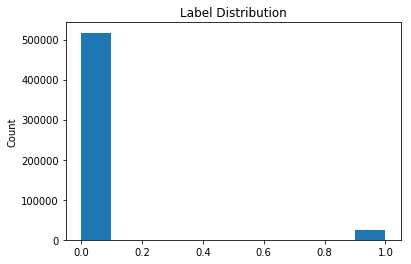

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y); plt.title('Label Distribution');
plt.ylabel('Count');

### Fill in Missing Values

We can fill in missing values using the median of the column. As an important note, the missing test values are filled in with the median of the corresponding training feature.

In [20]:
train = train.replace({np.inf: np.nan, -np.inf: np.nan}).\
    fillna(train.median())

In [21]:
test = test.replace({np.inf: np.nan, -np.inf: np.nan}).\
    fillna(train.median())

In [22]:
np.any(train.isnull()), np.any(np.isinf(train))

(False, False)

Now that there are no missing values and all of the values are numeric, our data is ready for machine learning. However, before we do machine learning, we need to figure out what a naive baseline would score.

# Naive Baseline

For a naive baseline, we can randomly guess that a customer has churned with the same frequence of the churns in the training data. We'll assess the predictions using a number of different metrics.

## Metrics

For an imbalanced classification problem, there are a number of metrics to consider:

* Receiver Operating Characteristic Area Under the Curve (ROC AUC): a measure between 0 and 1 comparing the performance of the classifier when predicting probabilities across a range of thresholds.
* Precision Score: number of true positives divided by the total number of positives predicted
* Recall Score: number of true positives divided by the total number of actual positives in the data
* F1 Score: Harmonic mean of precision and recall

The exact metric used and the threshold that our model needs to reach depends on the business need. We can tune the model to some extent to optimize for different metrics.

In [23]:
np.random.seed(50)
naive_guess = np.random.binomial(1, p = np.mean(y), size = len(test_y))
naive_guess[:10], naive_guess.sum()

(array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), 7709)

In [24]:
from sklearn.metrics import (roc_auc_score, precision_score, 
                             recall_score, f1_score)

print(f'Naive Baseline\n')
roc = roc_auc_score(test_y, np.repeat(np.mean(y), len(test_y)))
print(f'ROC AUC: {round(roc, 4)}')

for metric in [precision_score, recall_score, f1_score]:
    print(f'{metric.__name__}: {round(metric(test_y, naive_guess), 4)}')


Naive Baseline

ROC AUC: 0.5
precision_score: 0.0119
recall_score: 0.0483
f1_score: 0.0191


We can see that these metrics are very poor! With no machine learning, we are only able to identify 2.9% of the customer churns and only 0.9% of the predicted churns were actually churns. A naive approach clearly does not provide much value.

In [25]:
print(f'The percentage of churns is {100 * round(np.mean(y), 4)}% in the training data.')

The percentage of churns is 4.38% in the training data.


# Machine Learning

Now we need to see if machine learning is up to the task of improving on these predictions. We'll start simple, using a linear model to assess if this problem is easy enough to be solved with Logistic Regression. 

(The machine learning models are implemented in [Scikit-Learn](https://sklearn.org/)). 

## Baseline Model

We can use a logistic regression in order to see baseline performance on this problem. If the logistic regression works well enough, then there is no need to move to a more complex model.

In [26]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 50)

We can write a simple function to evaluate predictions. This implements the metrics used above. (A full list of metrics in Scikit-Learn can be found in [this documentation](http://scikit-learn.org/stable/modules/classes.html))

In [27]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score


def evaluate(model, train, y, test, test_y):
    """Evaluate a machine learning model on four metrics:
       ROC AUC, precision score, recall score, and f1 score.
       
       Returns the model and the predictions."""
    
    model.fit(train, y)

    # Predict probabilities and labels
    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)

    # Calculate ROC AUC
    roc = roc_auc_score(test_y, probs)
    name = repr(model).split('(')[0]
    print(f"{name}\n")
    print(f'ROC AUC: {round(roc, 4)}')

    # Iterate through metrics
    for metric in [precision_score, recall_score, f1_score]:
        # Use .__name__ attribute to list metric
        print(f'{metric.__name__}: {round(metric(test_y, preds), 4)}')

    return model, preds


model, preds = evaluate(model, train, y, test, test_y)

LogisticRegression

ROC AUC: 0.5356
precision_score: 0.003
recall_score: 0.0026
f1_score: 0.0028


The baseline model does perform slightly better than guessing in terms of ROC AUC. The precision is slightly higher than the naive baseline although the recall is much lower leading to an overall reduced f1 score (with a default threshold of 0.5 for classifying positive examples). This poor performance by the logistic regression indicates the problem of separating churn from not-churn is non-linear.

## More Complex Model

For a potentially better machine learning model, we can move to the [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). From the results of the logistic regression, this looks to be a non-linear problem which means we should use a model capable of learning a non-linear decision boundary.

We'll use most of the default hyperparameters but alter a few to prevent overfitting. We can also set `class_weight = 'balanced'` to try and offset the impact of such an imbalanced classification problem.

In [28]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=40,
                               min_samples_leaf = 50,
                               n_jobs=-1, class_weight = 'balanced',
                               random_state = 50)

model, preds = evaluate(model, train, y, test, test_y)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier

ROC AUC: 0.9965
precision_score: 0.3264
recall_score: 0.9926
f1_score: 0.4912


The random forest performance is much better than just guessing! With no tuning, the model is able to identify 36% of the customer churns and the false positives have been reduced. This should give us confidence that we can solve this problem using machine learning.

# Model Validation

We need to inspect the model results to determine if it meets our business needs. This includes looking at the performance as well as the feature importances. We want to make sure that our model performs well, but also try and understand _why_ it performs well. 

## Precision Recall Curve

One of the best methods for tuning a model for a business need is through the precision recall curve. This shows the precision-recall tradeoff for different thresholds. Depending on the business requirement, we can change the threshold for classifying a positive example to alter the balance of true positives, false positives, false negatives, and true negatives. There will always be a tradeoff between precision and recall, but we can try to find the right balance by visually and quantitatively assessing the model.

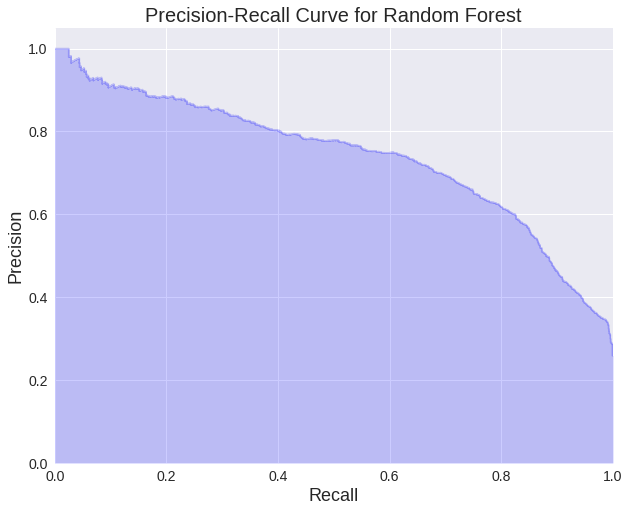

In [29]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn');

def plot_precision_recall(test_y, probs, title = 'Precision Recall Curve', threshold_selected = None):
    """Plot a precision recall curve for predictions. 
       Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py"""
    
    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize = (10, 8))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size = 18)
    plt.ylabel('Precision', size = 18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size = 20)
    plt.xticks(size = 14); plt.yticks(size = 14)
    
    if threshold_selected:
        p = precision(np.where(threshold == threshold_selected)[0])
        r = recall(np.where(threshold == threshold_selected)[0])
        plt.scatter(r, p, marker = '*', size = 200)
        plt.vlines(r, ymin = 0, ymax = p, linestyles = '--');
        plt.hlines(p, xmin = 0, xmax = r, linestyles = '--');
    
    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr
    
probs = model.predict_proba(test)[:, 1]
pr_data = plot_precision_recall(test_y, probs, title = 'Precision-Recall Curve for Random Forest')

We can query the dataframe to find the threshold required for a given precision or recall. For example, to find the threshold for a precision of 50%, we use the following code:

In [30]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.5].copy()
precision_above.sort_values('recall', ascending = False, inplace = True)
precision_above.head()

,precision,recall,threshold
3973,0.500000,0.880777,0.747705
3976,0.500448,0.880777,0.748020
3974,0.500149,0.880777,0.747868
3975,0.500298,0.880777,0.747884
3986,0.501646,0.880252,0.748703


There is no threshold at which our model achieves a precision greater than 50%! We could set the threshold at 1.0 which would result in no predicted instances of churn, thus achieving a precision of 100% and a recall of 0%.

### Adjusting for the Business Requirement

Let's say we are required to have a recall of 50% in our model. This means our model finds 50% of the true churns in the data. We'll work through the rest of this notebook under this assumption. To find the threshold, we use:

In [31]:
recall_above = pr_data.loc[pr_data['recall'] >= 0.5].copy()
recall_above.sort_values('precision', ascending = False, inplace = True)
recall_above.head()

,precision,recall,threshold
6099,0.779316,0.502626,0.946656
6090,0.779305,0.506303,0.946198
6100,0.779136,0.502101,0.946707
6091,0.779126,0.505777,0.946203
6087,0.779032,0.507353,0.946142


In [32]:
precision_attained = recall_above.iloc[0, 0]
threshold_required = recall_above.iloc[0, -1]

print(f'At a threshold of {round(threshold_required, 4)} the recall is 50% and the precision is {round(100 * precision_attained, 4)}%')

At a threshold of 0.9467 the recall is 50% and the precision is 77.9316%


This means that in order to identify 50% of the actual churns, we'll have to accept that only 3.6% of the predicted positives are actually positive churns. 

In [33]:
def plot_precision_recall(test_y, probs, title = 'Precision Recall Curve', threshold_selected = None):
    """Plot a precision recall curve for predictions. 
       Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py"""
    
    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize = (10, 10))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size = 24)
    plt.ylabel('Precision', size = 24)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size = 24)
    plt.xticks(size = 18); plt.yticks(size = 18)
    
    if threshold_selected:
        p = precision[np.where(threshold == threshold_selected)[0]]
        r = recall[np.where(threshold == threshold_selected)[0]]
        plt.scatter(r, p, marker = '*', s = 600, c = 'r')
        plt.vlines(r, ymin = 0, ymax = p, linestyles = '--');
        plt.hlines(p, xmin = 0, xmax = r, linestyles = '--');
        plt.text(r - 0.1, p + 0.15, 
                 s = f'Threshold: {round(threshold_selected, 2)}', size = 20, fontdict = {'weight': 1000})
        plt.text(r - 0.2, p + 0.075, 
                 s = f'Precision: {round(100 * p[0], 2)}% Recall: {round(100 * r[0], 2)}%', size = 20,
                fontdict = {'weight': 1000})
    
    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr

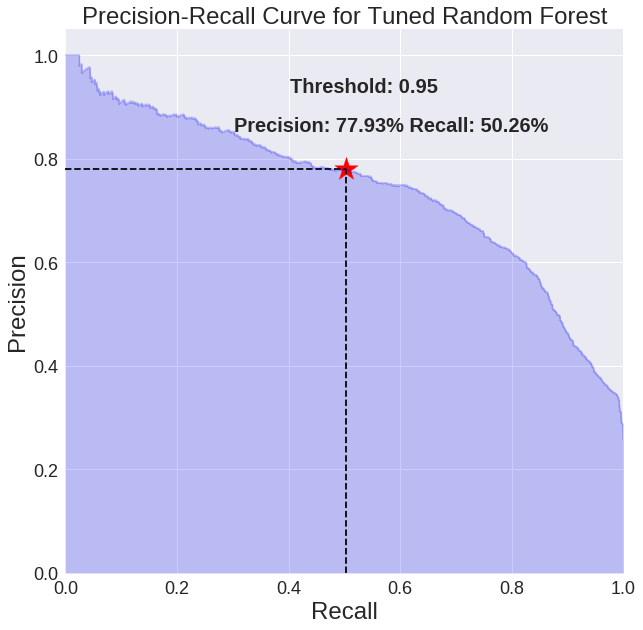

In [34]:
pr_data = plot_precision_recall(test_y, probs, title = 'Precision-Recall Curve for Tuned Random Forest',
                                threshold_selected = threshold_required)

## Confusion Matrix

A confusion matrix is often a useful way to visualize predictions. This shows the true values along the top row and the predicted values along the bottom row. Looking at the different cells, we can see where the model performed well and where it did not do so well.

We'll use the threshold identified above to construct the confusion matrix.

In [35]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.style.use('bmh')
    plt.figure(figsize = (9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 20)
    plt.yticks(tick_marks, classes, size = 20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size = 20)
    plt.grid(None)
    plt.ylabel('True label', size = 22)
    plt.xlabel('Predicted label', size = 22)
    plt.tight_layout()

Confusion matrix, without normalization
[[178039    271]
 [   947    957]]


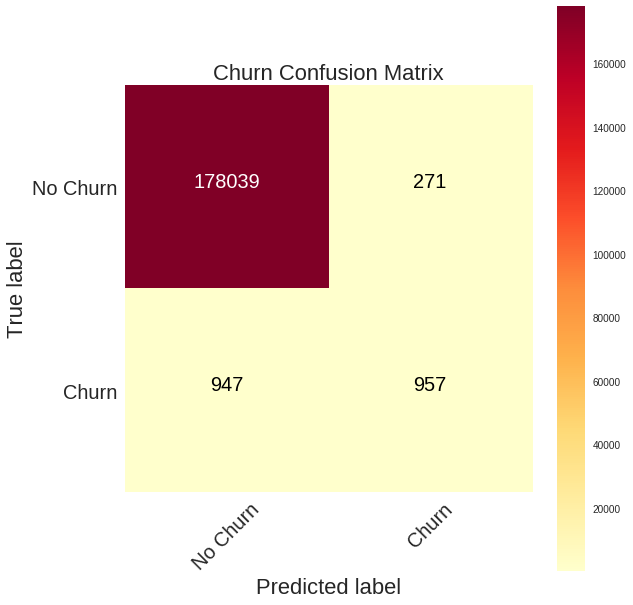

In [36]:
# Make predictions where probability is above threshold 
preds = np.zeros(len(test_y))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cm, classes = ['No Churn', 'Churn'],
                      title = 'Churn Confusion Matrix')

With our business requirement, this is the best prediction of what our performance would be on new data. The model is able to identiy 50% of churned customers compared to a baseline of around 3%. The precision has increased from the baseline 0.9% to 3.7%, a relative increase of over 300%. 

In [37]:
abs(0.0087 - 0.036) / 0.0087

3.1379310344827585

### Feature Importances

As one method for trying to understand how the model makes decisions, we can look at the most important features. The absolute value of the importances is not as useful as is the relative ranking of the features which is determined by how well the feature separates the classes when building the decision trees in the random forest.

In [38]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=train.columns).\
    sort_values('importance', ascending=False)
fi.head()

,importance
"TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)",0.147452
"TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, transaction_date)",0.120822
"TOTAL_PREVIOUS_MONTH(transactions.planned_daily_price, transaction_date)",0.097860
LAST(transactions.payment_method_id),0.034857
AVG_TIME_BETWEEN(transactions.transaction_date),0.032800


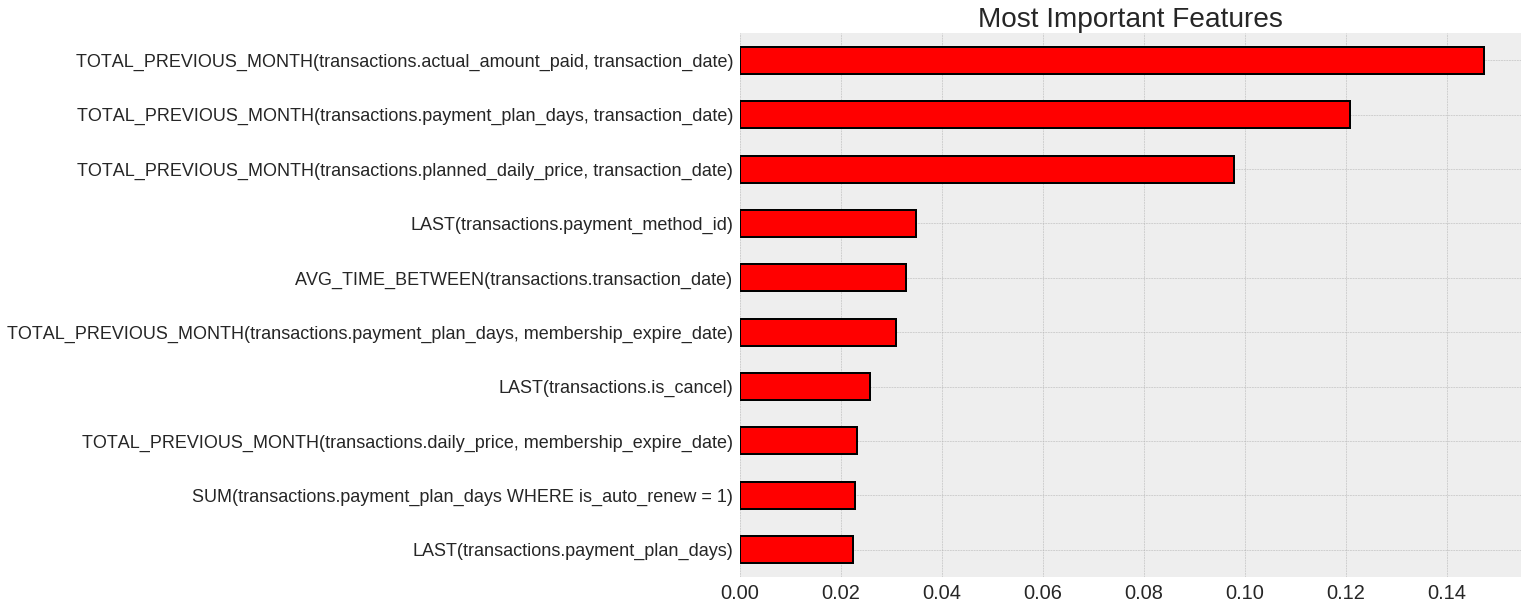

In [39]:
fi.iloc[:10]['importance'].plot.barh(color = 'r', edgecolor = 'k', 
                                     figsize = (14, 10), linewidth = 2)
ax = plt.gca()
ax.invert_yaxis();
plt.xticks(size = 20);
plt.yticks(size = 18)
plt.title('Most Important Features', size = 28);

To see why these features are important, we can plot the distribution colored by the value of the label.

In [41]:
def ecdf(x):
    n = len(x)
    x = np.sort(x)
    y = np.arange(1, n + 1) / n
    return x, y

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


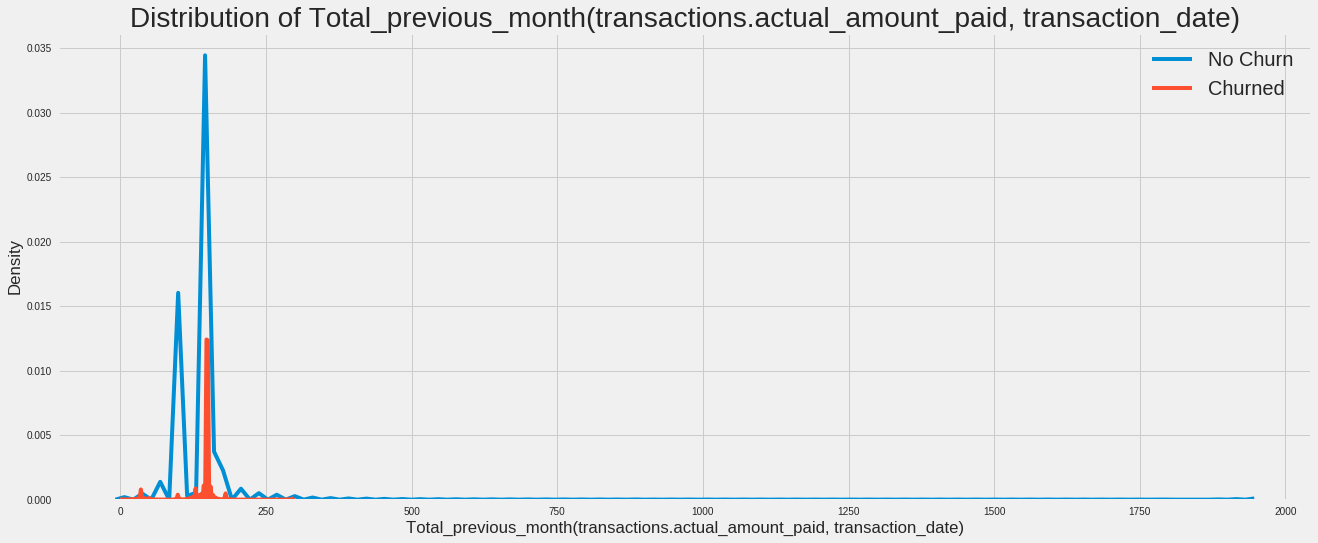

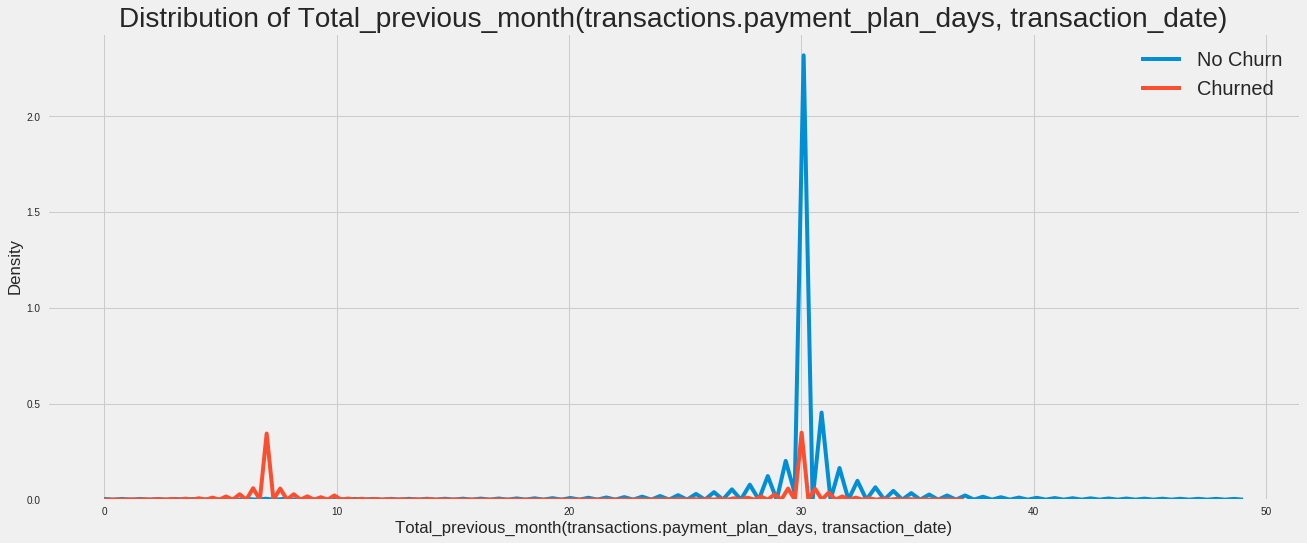

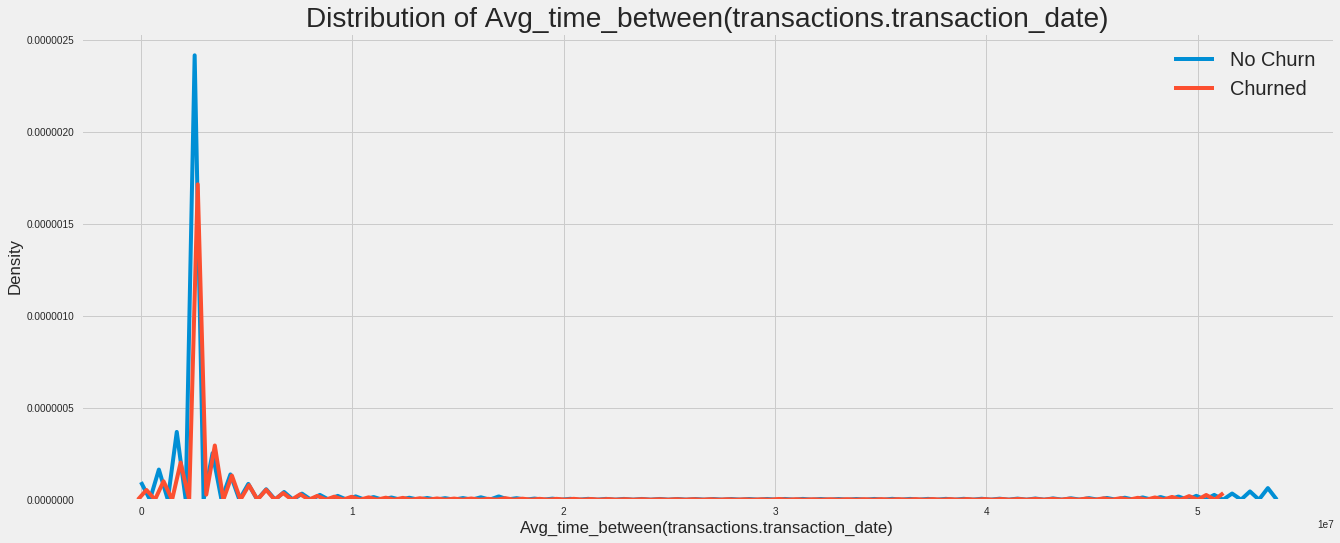

In [42]:
import seaborn as sns
plt.style.use('fivethirtyeight')

train_with_labels = train.copy()
train_with_labels['label'] = y
train_with_labels = train_with_labels[train_with_labels['TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, transaction_date)'] < 50]

# Iterate through features
for feature in ['TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)',
                'TOTAL_PREVIOUS_MONTH(transactions.payment_plan_days, transaction_date)',
                'AVG_TIME_BETWEEN(transactions.transaction_date)']:
    plt.figure(figsize = (20, 8))
    
    # Iterate through values of the label
    for label, grouped in train_with_labels.groupby('label'):
        # Plot the distribution of the feature
        sns.kdeplot(grouped[feature].dropna(), 
                    label = 'Churned' if label == 1 else 'No Churn');
    # Plot labeling
    plt.ylabel('Density'); plt.xlabel(f'{feature.capitalize()}')
    plt.title(f'Distribution of {feature.capitalize()}', size = 28);
    plt.legend(prop= {'size': 20});

There are significant differences between those customers who churned and those who did not. Most noticeably, the customers who churned had less activity in the previous month.

In [ ]:
train_with_labels['Time Since Last (Days)'] = train_with_labels['TIME_SINCE_LAST(transactions.transaction_date)'] / (3600 * 24)

In [ ]:
sns.violinplot(x = 'label', y = 'Time Since Last (Days)',
               data = train_with_labels, figsize = (10, 28));
plt.title('Violin Plot of Time Since Last Transaction');
plt.ylabel('Time Since Last Transaction (Days)')
plt.xticks([0, 1], ['No Churn', 'Churned']);

In [ ]:
sns.violinplot(x = 'label', y = 'TOTAL_PREVIOUS_MONTH(transactions.actual_amount_paid, transaction_date)',
               data = train_with_labels, 
               figsize = (10, 20));
plt.title('Violin Plot of Total Spent in Previous Month');
plt.ylabel('Total Spent in Previous Month')
plt.xticks([0, 1], ['No Churn', 'Churned']);

# Make Predictions

Now we will use the trained model to make predictions on the hold-out testing set. We'll can make predictions in terms of probabilities and then threshold them to labels using our selected threshold.

In [44]:
new_probs = model.predict_proba(test)[:, 1]

oos_ids = list(feature_matrix.iloc[test_start:]['msno'])
oos_cutoff_time = list(feature_matrix.iloc[test_start:]['cutoff_time'])

prediction_df = pd.DataFrame({'msno': oos_ids, 'cutoff_time': oos_cutoff_time, 
                              'probability': new_probs})
prediction_df['prediction'] = prediction_df['probability'] > threshold_required
prediction_df.sample(10)

,msno,cutoff_time,probability,prediction
109522,LLWeVTy6iIDms84SW9zC219IPUSLpDfZLXn6g/yGw50=,2017-01-01,0.006358,False
105044,u414S/O6aRUaSnszC+R9xUD4p8tw/XAXXWxJpSzG1Es=,2017-01-01,0.009657,False
117126,zbE4pLW4x5VwUphbCBya5huZacLpFAgVfRDHhUv9/pI=,2017-02-01,0.029171,False
90126,aJznHx8laI0skZJlil5yZUH7s187aNJUTHIBOs7ncXU=,2017-01-01,0.000000,False
142523,M6RhJwlvQI6phWr5FtkGFls5vJclQbM8F8//1lu9AV8=,2017-02-01,0.000000,False
155770,clVjlKWtApXFhkqeQJb+DfurgYHzMadZ48x/+LPetGk=,2017-03-01,0.000000,False
32650,mtbH8T17ynGKYAGC41EAXbR4lfr1t3MyxnTbWt2oL8g=,2016-11-01,0.000000,False
93744,vxSBjfiAyQfi3UbqG8+TOI/lCDCAGTA8T+4D3Knx0BM=,2017-01-01,0.016419,False
100709,Gu0dFFvo69itlphbI4VZIstt/fUXcnTz/S3FMO9rUJQ=,2017-01-01,0.064331,False
160061,fa4JFvtO6PTdyB9UFxsQz2QCCgIqVN7DNFATPfMN2MA=,2017-03-01,0.000000,False


In [45]:
to_show = ['lq1wtYrED2Lt+utU0U+vjcwesqY8OiH5eQ5MQATIxy4=', 
           'vlyt8UdHVr1QT8lbMO1d3aHxnaxCETny+TdaFd83MCs=']

show_preds = prediction_df.loc[prediction_df['msno'].isin(to_show)].copy()
show_preds.sort_values(['msno', 'cutoff_time'])

,msno,cutoff_time,probability,prediction
71269,lq1wtYrED2Lt+utU0U+vjcwesqY8OiH5eQ5MQATIxy4=,2016-12-01,0.000000,False
105263,lq1wtYrED2Lt+utU0U+vjcwesqY8OiH5eQ5MQATIxy4=,2017-01-01,0.031151,False
122972,lq1wtYrED2Lt+utU0U+vjcwesqY8OiH5eQ5MQATIxy4=,2017-02-01,0.041728,False
148923,lq1wtYrED2Lt+utU0U+vjcwesqY8OiH5eQ5MQATIxy4=,2017-03-01,0.036457,False


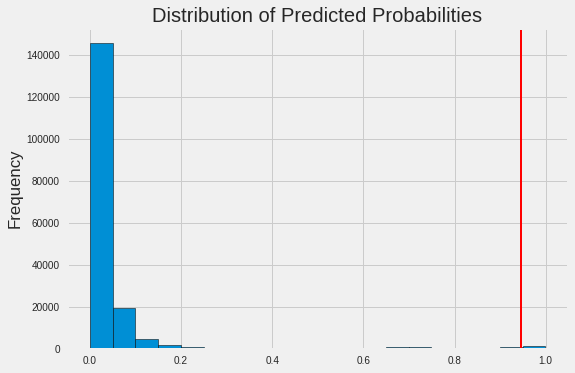

In [46]:
prediction_df['probability'].plot.hist(bins = 20, edgecolor = 'k');
plt.axvline(x = threshold_required, color = 'r', linewidth = 2)
plt.title('Distribution of Predicted Probabilities');

The model is fairly confident that most of the predictions are not churns. Moreover, there are a number of probabilities that are exactly the same as can be seen in the [empirical cumulative density function](https://en.wikipedia.org/wiki/Empirical_distribution_function). 

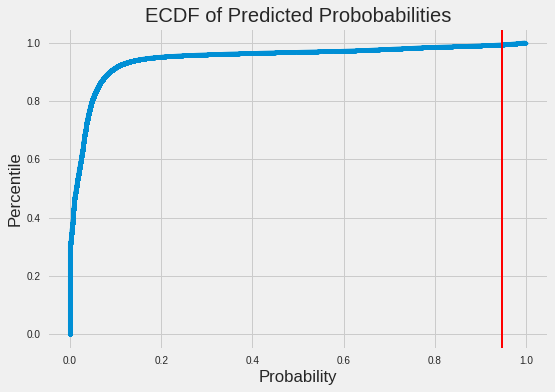

In [47]:
# Inspiration: https://campus.datacamp.com/courses/statistical-thinking-in-python-part-1/graphical-exploratory-data-analysis?ex=12
def ecdf(x):
    """Empirical Cumulative Density Function of x"""
    n = len(x)
    x = np.sort(x)
    y = np.arange(1, n + 1) / n
    return x, y

xs, ys = ecdf(prediction_df['probability'])
plt.plot(xs, ys, marker = '.');
plt.title('ECDF of Predicted Probobabilities');
plt.axvline(x = threshold_required, color = 'r', linewidth = 2);
plt.xlabel('Probability'); plt.ylabel('Percentile');

# Automated Model Optimization Using TPOT

If we are not pleased with the model results using an off-the-shelf algorithm from Scikit-Learn, there are a number of libraries for searching for the best model without any manual intervention. One of the easiest-to-se libraries is known as TPOT. This will search through hundreds of machine learning models, using evolutionary algorithms to guide the discovery process.

To evaluate the models, we'll use a TimeSeriesSplit. This makes three splits of the data based on the indexes so we need to ensure that our data is sorted by time (already done). 

In [48]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 3)

Now we make a `TPOTClassifier` object and pass in a few parameters. This particular use case will search 100 models, using `f1` scoring, the TimeSeriesSplit for cross validation, and taking advantage of all the cores on our machine.

In [50]:
from tpot import TPOTClassifier

# Make tpot pipeline
tpot_pipeline = TPOTClassifier(generations = 10, population_size = 10, 
                               cv = tss, scoring = 'f1', 
                               n_jobs = -1, verbosity = 2,
                               random_state = 50)

In [51]:
tpot_pipeline.fit(train, y)

Generation 1 - Current best internal CV score: 0.5833503851399626
Generation 2 - Current best internal CV score: 0.7286964140147464
Generation 3 - Current best internal CV score: 0.7286964140147464
Generation 4 - Current best internal CV score: 0.7287037052704913
Generation 5 - Current best internal CV score: 0.7287037052704913
Generation 6 - Current best internal CV score: 0.7287037052704913
Generation 7 - Current best internal CV score: 0.7287037052704913
Generation 8 - Current best internal CV score: 0.7287037052704913
Generation 9 - Current best internal CV score: 0.7287037052704913
Generation 10 - Current best internal CV score: 0.7287682151944667

Best pipeline: DecisionTreeClassifier(SelectPercentile(input_matrix, percentile=97), criterion=entropy, max_depth=7, min_samples_leaf=7, min_samples_split=3)


TPOTClassifier(config_dict=None, crossover_rate=0.1,
        cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
        disable_update_check=False, early_stop=None, generations=10,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=10,
        random_state=50, scoring='f1', subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

In [52]:
tpot_pipeline.fitted_pipeline_

Pipeline(memory=None,
     steps=[('selectpercentile', SelectPercentile(percentile=97,
         score_func=<function f_classif at 0x7fdaaa6bfd08>)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [53]:
tpot_pipeline.export('best_pipeline_new.py')

True

## Best Pipeline

The following code shows the best pipeline exported by TPOT. We can just copy the code, train a model, and make predictions. 

In [54]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('best_pipeline.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

In [55]:
from sklearn.ensemble import ExtraTreesClassifier

exported_pipeline = ExtraTreesClassifier(bootstrap=False, 
                                         criterion="entropy", 
                                         max_features=0.1, 
                                         min_samples_leaf=5, 
                                         min_samples_split=8, 
                                         n_estimators=100,
                                         random_state = 50,
                                         n_jobs = -1)

In [56]:
model, preds = evaluate(exported_pipeline, train, y, test, test_y)

ExtraTreesClassifier

ROC AUC: 0.9973
precision_score: 0.691
recall_score: 0.7847
f1_score: 0.7349


Now we can do the same procedure as before, looking at the precision recall curve and finding the threshold needed for a recall of 50%.

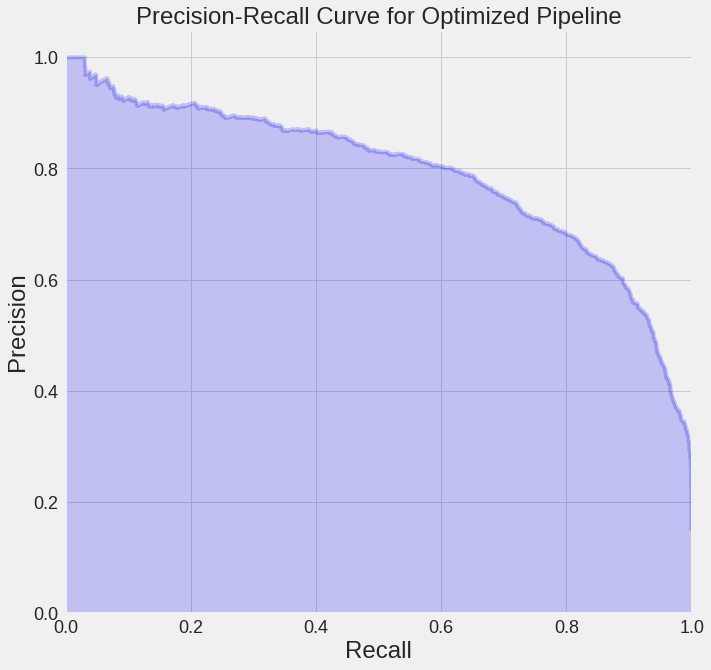

In [57]:
probs = model.predict_proba(test)[:, 1]
pr_data = plot_precision_recall(test_y, probs, title = 'Precision-Recall Curve for Optimized Pipeline')

In [58]:
recall_above = pr_data.loc[pr_data['recall'] >= 0.5].copy()
recall_above.sort_values('precision', ascending = False, inplace = True)
recall_above.head()

,precision,recall,threshold
10719,0.831158,0.501576,0.668674
10720,0.831010,0.501050,0.668833
10721,0.830863,0.500525,0.668866
10722,0.830716,0.500000,0.668903
10718,0.830435,0.501576,0.668316


In [59]:
precision_attained = recall_above.iloc[0, 0]
threshold_required = recall_above.iloc[0, -1]

print(f'At a threshold of {round(threshold_required, 4)} the recall is 50% and the precision is {round(100 * precision_attained, 4)}%')

At a threshold of 0.6687 the recall is 50% and the precision is 83.1158%


The Random Forest Classifier built by hand does slightly better than the TPOT optimized model. Running the optimization for longer may result in a better model. However, in terms of time investment, a better option is probably to spend more time on feature engineering. 

Confusion matrix, without normalization
[[178116    194]
 [   949    955]]


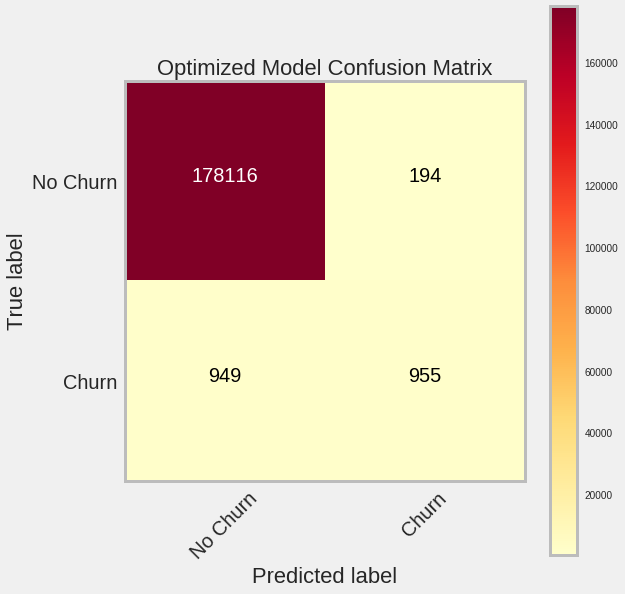

In [60]:
preds = np.zeros(len(test_y))
preds[probs >= threshold_required] = 1

cm = confusion_matrix(test_y, preds)
plot_confusion_matrix(cm, classes = ['No Churn', 'Churn'], 
                      title = 'Optimized Model Confusion Matrix')

# Conclusions

Our final tuned model was able to achieve a recall of 50% and a precision of 3.6%, a significant increase over the naive baseline of 2.9% recall and 0.9% precision. 

Overall, the final metrics from modeling are:

| Model                                     | ROC AUC | Recall | Precision | F1 Score |
|-------------------------------------------|---------|--------|-----------|----------|
| Naive Baseline (no ml)                    | 0.5     | 3.54%  | 1.05%     | 0.0162   |
| Logistic Regression                       | 0.567   | 0.19%  | 1.13%     | 0.0032   |
| Random Forest Default                     | 0.709   | 35.9%  | 6.41%     | 0.1088   |
| Random Forest Tuned for 50% Recall        | 0.709   | 50%    | 3.63%     | 0.0677   |
| Auto-optimized Model                      | 0.709   | 0.15%  | 2.63%     | 0.0028   |
| Auto-optimized Model Tuned for 50% Recall | 0.709   | 50%    | 3.30%     | 0.0617   |

With these metrics, we can conclude that machine learning has solved the business problem of identifying customers that will churn in the next month. We can now use this model to predict customers at risk for churning in the future. These predictions would then be handed off to the customer engagement team to hopefully reduce the number of churns. 

The framework for solving this problem - and for solving any problem with machine learning - was:

1. Prediction Engineering: define the business objective, translate into a machine learning task, and create a set of labeled historical examples with cutoff time from the data.
2. Feature Engineering: use the label times to automatically build hundreds of relevant and valid features for each label.
3. Modeling: use a machine learning algorithm implemented in common Python libraries to train a model to predit the labels from the features. Validate and tune model for the business need and then make predictions on new data.

This approach solves a number of problems: it standardizes the traditionally ad-hoc process of solving a problem with machine learning and it is general so that nearly the same code can be used for multiple prediction problems on the same dataset. The benefits of machine learning have been limited to a few companies both because of the lack of a shared language for expressing and solving problems, and because each solution requires custom code and must be completely rebuilt for a different prediction problem. By codifying the processes needed to solve problems with machine learning, we aim to make it easier for companies to use this transformational technology. The achievements of machine learning are already impressive, but with a scaffolding in place the benefits can be extended to a broader population.
